In [ ]:
import sys
import os
# Manually set the project root directory (adjust if needed)
project_root = os.path.abspath(os.path.join('..', '..'))  # Moves up one level to project root
# Add the project directory to sys.path
sys.path.append(project_root)

### Create/ Clean Model Weight Directory

In [ ]:
from Training.Helper.weightFileCleaner import cleanWeightFiles
model_save_path = os.path.join('.')
cleanWeightFiles('RNN', dirPath=model_save_path, earlyStopped=False, verbose=True)

### Load Data

In [ ]:
import pandas as pd

# **Define relative file path for training data**
train_file = os.path.join('..', '..', 'Data', 'Train', 'train1990s.csv')

# **Load Training Data with Automatic Column Detection**
train_df = pd.read_csv(train_file)
#print("Columns in dataset:", train_df.columns)  # Debugging: Show available columns

In [ ]:
date_col = 'observation_date'
target_col = 'fred_PCEPI'

In [ ]:
from Training.Helper.dataPreprocessing import sklearn_fit_transform
from sklearn.preprocessing import MinMaxScaler
 
# **Normalize Data**
# Perform min-max scaling on input data (no exogenous variables)
train_dataframes, scaler = sklearn_fit_transform(pd.DataFrame(train_df[target_col]), MinMaxScaler())
# Returns list of DataFrames, so extract correct DataFrame, then extract values, then reshape
train_series = train_dataframes[0].values.reshape(1, -1)[0]

In [ ]:
from Training.Helper.dataPreprocessing import create_sequences

# **Set Sequence Length**
# Create sequences from the training series
sequence_length = 12
X, y = create_sequences(train_series, train_series, sequence_length)

In [ ]:
from sklearn.model_selection import train_test_split

# **Train-Validation Split (80% Train, 20% Validation)**
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=False)

In [ ]:
from Training.Helper.dataPreprocessing import add_dimension

# Reshape data as expected
X_train, y_train, X_val, y_val = [add_dimension(dataset) for dataset in [X_train, y_train, X_val, y_val]]

In [ ]:
from Training.Helper.dataPreprocessing import prepare_dataloader

# **Create DataLoaders**
batch_size = 32
train_loader = prepare_dataloader(X_train, y_train, batch_size=batch_size, shuffle=False)
val_loader = prepare_dataloader(X_val, y_val, batch_size=batch_size, shuffle=False)

### Train Model

In [ ]:
# Now import the RNN model
from Models.RNN import RNNModel
from Training.Helper.PyTorchModular import train_model
import torch
import torch.optim as optim
import torch.nn as nn


# **Train Model Using Modular Functions**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model = RNNModel(input_size=1, hidden_size=64, num_layers=2).to(device)

# **Define Loss Function and Optimizer**
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# **Train the Model Using Modular Functions**
train_data = train_model(
    model=rnn_model,
    maxEpochs=50,
    modelSavePath=model_save_path,
    modelName="RNN",
    dataLoaderTrain=train_loader,
    dataLoaderValid=val_loader,
    lossFn=criterion,
    optimizer=optimizer,
    device=device,
    batchStatusUpdate=10,
    verbose=True
)

### Evaluate

In [ ]:
from Training.Helper.PyTorchModular import train_model, loss_curve

# **Plot Training vs. Validation Loss**
loss_curve(trainLoss=train_data["trainLoss"], validLoss=train_data["validLoss"], title="RNN Training vs. Validation Loss")

In [ ]:
from Evaluation.Helper.evaluation_helpers import get_best_model_path, evaluate_model

# Get path of the best model
best_model_path = get_best_model_path(model_save_path, 'RNN')

# **Extract the dates corresponding to the validation predictions**
val_dates = train_df[date_col].iloc[len(X_train) + sequence_length:].values

# Plot evaluation plot of the best model (loaded from path above) and get metrics
eval_axes, metrics = evaluate_model(rnn_model, val_loader, scaler, val_dates, device, savepath=best_model_path, print_dates=10)

In [ ]:
# **Display metrics for Validation Predictions**
print("Metrics for RNN model:")
display(metrics)

In [ ]:
# Example usage of weight file cleaner, uncomment if needed

#from Training.Helper.weightFileCleaner import cleanWeightFiles
#cleanWeightFiles('RNN', earlyStopped=True, verbose=True)

[I 2025-04-09 12:30:55,327] A new study created in memory with name: no-name-ea16ccdd-de2a-4dc2-b790-373a80a36363


Epoch 1/50 | Train Loss: 0.0159 | Val Loss: 0.0403
Epoch 2/50 | Train Loss: 0.0956 | Val Loss: 0.0636
Epoch 3/50 | Train Loss: 0.0943 | Val Loss: 0.2442
Epoch 4/50 | Train Loss: 0.0294 | Val Loss: 0.0777
Epoch 5/50 | Train Loss: 0.0448 | Val Loss: 0.0466
Epoch 6/50 | Train Loss: 0.0101 | Val Loss: 0.0131
Epoch 7/50 | Train Loss: 0.0840 | Val Loss: 0.1854
Epoch 8/50 | Train Loss: 0.0675 | Val Loss: 0.2253
Epoch 9/50 | Train Loss: 0.0200 | Val Loss: 0.0316
Epoch 10/50 | Train Loss: 0.0349 | Val Loss: 0.0123
Epoch 11/50 | Train Loss: 0.0126 | Val Loss: 0.0126
Epoch 12/50 | Train Loss: 0.0379 | Val Loss: 0.1031
Epoch 13/50 | Train Loss: 0.0077 | Val Loss: 0.0044
Epoch 14/50 | Train Loss: 0.0080 | Val Loss: 0.0085
Epoch 15/50 | Train Loss: 0.0408 | Val Loss: 0.1526
Epoch 16/50 | Train Loss: 0.0307 | Val Loss: 0.1479
Epoch 17/50 | Train Loss: 0.0301 | Val Loss: 0.1266


[I 2025-04-09 12:30:57,629] Trial 0 finished with value: 0.004438829996312658 and parameters: {'hidden_size': 171, 'num_layers': 3, 'dropout': 0.4615859567257532, 'lr': 0.0009099269783592008, 'weight_decay': 2.4090047000613167e-05}. Best is trial 0 with value: 0.004438829996312658.


 Early stopping at epoch 17
Epoch 1/50 | Train Loss: 0.1048 | Val Loss: 0.0143
Epoch 2/50 | Train Loss: 0.3650 | Val Loss: 0.2419
Epoch 3/50 | Train Loss: 0.6045 | Val Loss: 0.0173
Epoch 4/50 | Train Loss: 0.3315 | Val Loss: 0.0998
Epoch 5/50 | Train Loss: 0.1291 | Val Loss: 0.0897


[I 2025-04-09 12:30:58,232] Trial 1 finished with value: 0.014307145650188128 and parameters: {'hidden_size': 234, 'num_layers': 2, 'dropout': 0.3805092764649035, 'lr': 0.0031671607285410045, 'weight_decay': 0.0013490917418740459}. Best is trial 0 with value: 0.004438829996312658.


 Early stopping at epoch 5
Epoch 1/50 | Train Loss: 0.1059 | Val Loss: 0.5398
Epoch 2/50 | Train Loss: 0.0963 | Val Loss: 0.5143
Epoch 3/50 | Train Loss: 0.0891 | Val Loss: 0.4900
Epoch 4/50 | Train Loss: 0.0826 | Val Loss: 0.4673
Epoch 5/50 | Train Loss: 0.0732 | Val Loss: 0.4459
Epoch 6/50 | Train Loss: 0.0678 | Val Loss: 0.4260
Epoch 7/50 | Train Loss: 0.0628 | Val Loss: 0.4071
Epoch 8/50 | Train Loss: 0.0610 | Val Loss: 0.3892
Epoch 9/50 | Train Loss: 0.0557 | Val Loss: 0.3723
Epoch 10/50 | Train Loss: 0.0536 | Val Loss: 0.3563
Epoch 11/50 | Train Loss: 0.0477 | Val Loss: 0.3412
Epoch 12/50 | Train Loss: 0.0449 | Val Loss: 0.3273
Epoch 13/50 | Train Loss: 0.0415 | Val Loss: 0.3145
Epoch 14/50 | Train Loss: 0.0411 | Val Loss: 0.3027
Epoch 15/50 | Train Loss: 0.0411 | Val Loss: 0.2914
Epoch 16/50 | Train Loss: 0.0370 | Val Loss: 0.2809
Epoch 17/50 | Train Loss: 0.0371 | Val Loss: 0.2718
Epoch 18/50 | Train Loss: 0.0362 | Val Loss: 0.2636
Epoch 19/50 | Train Loss: 0.0354 | Val Loss: 0

[I 2025-04-09 12:31:02,942] Trial 2 finished with value: 0.1685639371474584 and parameters: {'hidden_size': 90, 'num_layers': 3, 'dropout': 0.295101886169875, 'lr': 1.196087860958057e-05, 'weight_decay': 2.8137933422589264e-06}. Best is trial 0 with value: 0.004438829996312658.


Epoch 50/50 | Train Loss: 0.0269 | Val Loss: 0.1686
Epoch 1/50 | Train Loss: 0.8014 | Val Loss: 0.1581
Epoch 2/50 | Train Loss: 0.1412 | Val Loss: 0.0297
Epoch 3/50 | Train Loss: 0.1141 | Val Loss: 0.0333
Epoch 4/50 | Train Loss: 0.1911 | Val Loss: 0.0350
Epoch 5/50 | Train Loss: 0.3530 | Val Loss: 0.1848


[I 2025-04-09 12:31:03,732] Trial 3 finished with value: 0.029705871692082535 and parameters: {'hidden_size': 230, 'num_layers': 2, 'dropout': 0.18350860391525334, 'lr': 0.006956973165714095, 'weight_decay': 4.724685292229707e-05}. Best is trial 0 with value: 0.004438829996312658.


Epoch 6/50 | Train Loss: 0.5090 | Val Loss: 0.4027
 Early stopping at epoch 6
Epoch 1/50 | Train Loss: 1.2651 | Val Loss: 1.1100
Epoch 2/50 | Train Loss: 0.3662 | Val Loss: 0.0474
Epoch 3/50 | Train Loss: 0.1285 | Val Loss: 0.1172
Epoch 4/50 | Train Loss: 0.0175 | Val Loss: 0.0629
Epoch 5/50 | Train Loss: 0.0638 | Val Loss: 0.0228
Epoch 6/50 | Train Loss: 0.1999 | Val Loss: 0.0243
Epoch 7/50 | Train Loss: 0.1994 | Val Loss: 0.0168
Epoch 8/50 | Train Loss: 0.0586 | Val Loss: 0.0186
Epoch 9/50 | Train Loss: 0.0634 | Val Loss: 0.1916


[I 2025-04-09 12:31:04,406] Trial 4 finished with value: 0.01683851145207882 and parameters: {'hidden_size': 236, 'num_layers': 1, 'dropout': 0.30257630508680466, 'lr': 0.0062510690529613885, 'weight_decay': 4.388556516969702e-06}. Best is trial 0 with value: 0.004438829996312658.


Epoch 10/50 | Train Loss: 0.0327 | Val Loss: 0.0683
Epoch 11/50 | Train Loss: 0.0895 | Val Loss: 0.0542
 Early stopping at epoch 11
Epoch 1/50 | Train Loss: 0.0112 | Val Loss: 0.0444
Epoch 2/50 | Train Loss: 0.0918 | Val Loss: 0.2252
Epoch 3/50 | Train Loss: 0.0426 | Val Loss: 0.2558
Epoch 4/50 | Train Loss: 0.0253 | Val Loss: 0.1679


[I 2025-04-09 12:31:04,846] Trial 5 finished with value: 0.044404899779086314 and parameters: {'hidden_size': 100, 'num_layers': 2, 'dropout': 0.22656600125446566, 'lr': 0.0003511279096224977, 'weight_decay': 0.009266768264533364}. Best is trial 0 with value: 0.004438829996312658.


Epoch 5/50 | Train Loss: 0.0244 | Val Loss: 0.1215
 Early stopping at epoch 5
Epoch 1/50 | Train Loss: 0.0663 | Val Loss: 0.0221
Epoch 2/50 | Train Loss: 0.1130 | Val Loss: 0.0763
Epoch 3/50 | Train Loss: 0.1857 | Val Loss: 0.0280
Epoch 4/50 | Train Loss: 0.1078 | Val Loss: 0.0618
Epoch 5/50 | Train Loss: 0.0650 | Val Loss: 0.0110
Epoch 6/50 | Train Loss: 0.0502 | Val Loss: 0.0229
Epoch 7/50 | Train Loss: 0.0368 | Val Loss: 0.1238
Epoch 8/50 | Train Loss: 0.0438 | Val Loss: 0.0069
Epoch 9/50 | Train Loss: 0.0484 | Val Loss: 0.0089
Epoch 10/50 | Train Loss: 0.0191 | Val Loss: 0.0745
Epoch 11/50 | Train Loss: 0.0118 | Val Loss: 0.0161
Epoch 12/50 | Train Loss: 0.0115 | Val Loss: 0.0110


[I 2025-04-09 12:31:07,160] Trial 6 finished with value: 0.006933149415999651 and parameters: {'hidden_size': 239, 'num_layers': 3, 'dropout': 0.49116990252892323, 'lr': 0.0018081877553495695, 'weight_decay': 6.92627314698829e-06}. Best is trial 0 with value: 0.004438829996312658.


 Early stopping at epoch 12
Epoch 1/50 | Train Loss: 1.0289 | Val Loss: 0.3157
Epoch 2/50 | Train Loss: 0.9572 | Val Loss: 0.0832
Epoch 3/50 | Train Loss: 1.8119 | Val Loss: 0.5339
Epoch 4/50 | Train Loss: 0.0543 | Val Loss: 0.0411
Epoch 5/50 | Train Loss: 4.2212 | Val Loss: 1.4678
Epoch 6/50 | Train Loss: 0.4719 | Val Loss: 0.0570
Epoch 7/50 | Train Loss: 0.1870 | Val Loss: 0.0188
Epoch 8/50 | Train Loss: 0.3231 | Val Loss: 0.4147
Epoch 9/50 | Train Loss: 0.0249 | Val Loss: 0.1136
Epoch 10/50 | Train Loss: 0.0952 | Val Loss: 0.0968
Epoch 11/50 | Train Loss: 0.1263 | Val Loss: 0.1771
 Early stopping at epoch 11


[I 2025-04-09 12:31:07,789] Trial 7 finished with value: 0.01884871255606413 and parameters: {'hidden_size': 140, 'num_layers': 1, 'dropout': 0.11604704305006619, 'lr': 0.009956989890569198, 'weight_decay': 6.231040826282073e-05}. Best is trial 0 with value: 0.004438829996312658.


Epoch 1/50 | Train Loss: 0.1413 | Val Loss: 0.6232
Epoch 2/50 | Train Loss: 0.1216 | Val Loss: 0.5888
Epoch 3/50 | Train Loss: 0.1079 | Val Loss: 0.5564
Epoch 4/50 | Train Loss: 0.0994 | Val Loss: 0.5262
Epoch 5/50 | Train Loss: 0.0960 | Val Loss: 0.4980
Epoch 6/50 | Train Loss: 0.0885 | Val Loss: 0.4713
Epoch 7/50 | Train Loss: 0.0757 | Val Loss: 0.4465
Epoch 8/50 | Train Loss: 0.0687 | Val Loss: 0.4236
Epoch 9/50 | Train Loss: 0.0665 | Val Loss: 0.4025
Epoch 10/50 | Train Loss: 0.0579 | Val Loss: 0.3836
Epoch 11/50 | Train Loss: 0.0572 | Val Loss: 0.3661
Epoch 12/50 | Train Loss: 0.0523 | Val Loss: 0.3498
Epoch 13/50 | Train Loss: 0.0513 | Val Loss: 0.3357
Epoch 14/50 | Train Loss: 0.0480 | Val Loss: 0.3229
Epoch 15/50 | Train Loss: 0.0474 | Val Loss: 0.3113
Epoch 16/50 | Train Loss: 0.0497 | Val Loss: 0.3013
Epoch 17/50 | Train Loss: 0.0479 | Val Loss: 0.2922
Epoch 18/50 | Train Loss: 0.0450 | Val Loss: 0.2840
Epoch 19/50 | Train Loss: 0.0435 | Val Loss: 0.2761
Epoch 20/50 | Train L

[I 2025-04-09 12:31:12,931] Trial 8 finished with value: 0.21032342066367468 and parameters: {'hidden_size': 86, 'num_layers': 3, 'dropout': 0.49732904510196463, 'lr': 1.1464998033721822e-05, 'weight_decay': 0.0001746224981984545}. Best is trial 0 with value: 0.004438829996312658.


Epoch 49/50 | Train Loss: 0.0406 | Val Loss: 0.2111
Epoch 50/50 | Train Loss: 0.0409 | Val Loss: 0.2103
Epoch 1/50 | Train Loss: 0.0790 | Val Loss: 0.3383
Epoch 2/50 | Train Loss: 0.0190 | Val Loss: 0.1452
Epoch 3/50 | Train Loss: 0.0345 | Val Loss: 0.1409
Epoch 4/50 | Train Loss: 0.0330 | Val Loss: 0.1669
Epoch 5/50 | Train Loss: 0.0266 | Val Loss: 0.1566
Epoch 6/50 | Train Loss: 0.0222 | Val Loss: 0.1261
Epoch 7/50 | Train Loss: 0.0203 | Val Loss: 0.1013
Epoch 8/50 | Train Loss: 0.0180 | Val Loss: 0.0812
Epoch 9/50 | Train Loss: 0.0129 | Val Loss: 0.0485
Epoch 10/50 | Train Loss: 0.0064 | Val Loss: 0.0133
Epoch 11/50 | Train Loss: 0.0015 | Val Loss: 0.0042


[I 2025-04-09 12:31:13,708] Trial 9 finished with value: 0.0041717387503013015 and parameters: {'hidden_size': 127, 'num_layers': 1, 'dropout': 0.14943231075186336, 'lr': 0.0002453127729344484, 'weight_decay': 0.0006197497105786912}. Best is trial 9 with value: 0.0041717387503013015.


Epoch 12/50 | Train Loss: 0.0048 | Val Loss: 0.0111
Epoch 13/50 | Train Loss: 0.0052 | Val Loss: 0.0237
Epoch 14/50 | Train Loss: 0.0026 | Val Loss: 0.0098
Epoch 15/50 | Train Loss: 0.0009 | Val Loss: 0.0048
 Early stopping at epoch 15
Epoch 1/50 | Train Loss: 0.0899 | Val Loss: 0.4633
Epoch 2/50 | Train Loss: 0.0633 | Val Loss: 0.3813
Epoch 3/50 | Train Loss: 0.0445 | Val Loss: 0.3087
Epoch 4/50 | Train Loss: 0.0325 | Val Loss: 0.2469
Epoch 5/50 | Train Loss: 0.0271 | Val Loss: 0.2008
Epoch 6/50 | Train Loss: 0.0265 | Val Loss: 0.1741
Epoch 7/50 | Train Loss: 0.0272 | Val Loss: 0.1629
Epoch 8/50 | Train Loss: 0.0272 | Val Loss: 0.1594
Epoch 9/50 | Train Loss: 0.0264 | Val Loss: 0.1572
Epoch 10/50 | Train Loss: 0.0254 | Val Loss: 0.1536
Epoch 11/50 | Train Loss: 0.0243 | Val Loss: 0.1483
Epoch 12/50 | Train Loss: 0.0233 | Val Loss: 0.1418
Epoch 13/50 | Train Loss: 0.0224 | Val Loss: 0.1349
Epoch 14/50 | Train Loss: 0.0214 | Val Loss: 0.1279
Epoch 15/50 | Train Loss: 0.0204 | Val Loss: 

[I 2025-04-09 12:31:15,393] Trial 10 finished with value: 0.0052581432973966 and parameters: {'hidden_size': 157, 'num_layers': 1, 'dropout': 0.10268301848764089, 'lr': 7.059346225090942e-05, 'weight_decay': 0.0007358042912077691}. Best is trial 9 with value: 0.0041717387503013015.


Epoch 30/50 | Train Loss: 0.0008 | Val Loss: 0.0064
Epoch 31/50 | Train Loss: 0.0008 | Val Loss: 0.0066
Epoch 32/50 | Train Loss: 0.0008 | Val Loss: 0.0065
 Early stopping at epoch 32
Epoch 1/50 | Train Loss: 0.0077 | Val Loss: 0.0325
Epoch 2/50 | Train Loss: 0.1036 | Val Loss: 0.3292
Epoch 3/50 | Train Loss: 0.0243 | Val Loss: 0.1235
Epoch 4/50 | Train Loss: 0.0320 | Val Loss: 0.1055
Epoch 5/50 | Train Loss: 0.0157 | Val Loss: 0.0048
Epoch 6/50 | Train Loss: 0.0072 | Val Loss: 0.0479
Epoch 7/50 | Train Loss: 0.1465 | Val Loss: 0.1302
Epoch 8/50 | Train Loss: 0.0251 | Val Loss: 0.1396
Epoch 9/50 | Train Loss: 0.0260 | Val Loss: 0.1229


[I 2025-04-09 12:31:16,384] Trial 11 finished with value: 0.004844024932632844 and parameters: {'hidden_size': 185, 'num_layers': 2, 'dropout': 0.39783765472147536, 'lr': 0.0005159321008612442, 'weight_decay': 1.9973888599110977e-05}. Best is trial 9 with value: 0.0041717387503013015.


 Early stopping at epoch 9
Epoch 1/50 | Train Loss: 0.1496 | Val Loss: 0.6056
Epoch 2/50 | Train Loss: 0.1045 | Val Loss: 0.4933
Epoch 3/50 | Train Loss: 0.0677 | Val Loss: 0.3841
Epoch 4/50 | Train Loss: 0.0402 | Val Loss: 0.2824
Epoch 5/50 | Train Loss: 0.0265 | Val Loss: 0.2051
Epoch 6/50 | Train Loss: 0.0263 | Val Loss: 0.1678
Epoch 7/50 | Train Loss: 0.0290 | Val Loss: 0.1613
Epoch 8/50 | Train Loss: 0.0288 | Val Loss: 0.1643
Epoch 9/50 | Train Loss: 0.0273 | Val Loss: 0.1644
Epoch 10/50 | Train Loss: 0.0257 | Val Loss: 0.1595
Epoch 11/50 | Train Loss: 0.0244 | Val Loss: 0.1517
Epoch 12/50 | Train Loss: 0.0233 | Val Loss: 0.1433
Epoch 13/50 | Train Loss: 0.0223 | Val Loss: 0.1355
Epoch 14/50 | Train Loss: 0.0212 | Val Loss: 0.1282
Epoch 15/50 | Train Loss: 0.0201 | Val Loss: 0.1209
Epoch 16/50 | Train Loss: 0.0189 | Val Loss: 0.1132
Epoch 17/50 | Train Loss: 0.0176 | Val Loss: 0.1049
Epoch 18/50 | Train Loss: 0.0162 | Val Loss: 0.0960
Epoch 19/50 | Train Loss: 0.0147 | Val Loss: 0

[I 2025-04-09 12:31:18,035] Trial 12 finished with value: 0.0070697960909456015 and parameters: {'hidden_size': 126, 'num_layers': 1, 'dropout': 0.3990667557375685, 'lr': 8.858936761214412e-05, 'weight_decay': 0.0004702780588969279}. Best is trial 9 with value: 0.0041717387503013015.


Epoch 33/50 | Train Loss: 0.0008 | Val Loss: 0.0081
 Early stopping at epoch 33
Epoch 1/50 | Train Loss: 0.0214 | Val Loss: 0.0297
Epoch 2/50 | Train Loss: 0.1088 | Val Loss: 0.2085
Epoch 3/50 | Train Loss: 0.0490 | Val Loss: 0.1099
Epoch 4/50 | Train Loss: 0.0419 | Val Loss: 0.0388
Epoch 5/50 | Train Loss: 0.0217 | Val Loss: 0.0040
Epoch 6/50 | Train Loss: 0.0332 | Val Loss: 0.1811
Epoch 7/50 | Train Loss: 0.0410 | Val Loss: 0.1790
Epoch 8/50 | Train Loss: 0.0286 | Val Loss: 0.1014


[I 2025-04-09 12:31:19,582] Trial 13 finished with value: 0.003985883512844642 and parameters: {'hidden_size': 188, 'num_layers': 3, 'dropout': 0.22461129186083112, 'lr': 0.0008960209928149922, 'weight_decay': 1.0805309380407462e-06}. Best is trial 13 with value: 0.003985883512844642.


Epoch 9/50 | Train Loss: 0.0175 | Val Loss: 0.0081
 Early stopping at epoch 9
Epoch 1/50 | Train Loss: 0.0575 | Val Loss: 0.1998
Epoch 2/50 | Train Loss: 0.0356 | Val Loss: 0.1464
Epoch 3/50 | Train Loss: 0.0406 | Val Loss: 0.1880
Epoch 4/50 | Train Loss: 0.0317 | Val Loss: 0.1849
Epoch 5/50 | Train Loss: 0.0253 | Val Loss: 0.1475
Epoch 6/50 | Train Loss: 0.0233 | Val Loss: 0.1186
Epoch 7/50 | Train Loss: 0.0216 | Val Loss: 0.0971
Epoch 8/50 | Train Loss: 0.0164 | Val Loss: 0.0612
Epoch 9/50 | Train Loss: 0.0091 | Val Loss: 0.0189
Epoch 10/50 | Train Loss: 0.0027 | Val Loss: 0.0033
Epoch 11/50 | Train Loss: 0.0037 | Val Loss: 0.0070
Epoch 12/50 | Train Loss: 0.0031 | Val Loss: 0.0096


[I 2025-04-09 12:31:21,199] Trial 14 finished with value: 0.0033361168267826238 and parameters: {'hidden_size': 198, 'num_layers': 2, 'dropout': 0.1833389747435502, 'lr': 0.0001260782805310485, 'weight_decay': 1.0225853341391187e-06}. Best is trial 14 with value: 0.0033361168267826238.


Epoch 13/50 | Train Loss: 0.0039 | Val Loss: 0.0081
Epoch 14/50 | Train Loss: 0.0013 | Val Loss: 0.0035
 Early stopping at epoch 14
Epoch 1/50 | Train Loss: 0.0840 | Val Loss: 0.3682
Epoch 2/50 | Train Loss: 0.0255 | Val Loss: 0.1937
Epoch 3/50 | Train Loss: 0.0411 | Val Loss: 0.1847
Epoch 4/50 | Train Loss: 0.0407 | Val Loss: 0.2075
Epoch 5/50 | Train Loss: 0.0336 | Val Loss: 0.1999
Epoch 6/50 | Train Loss: 0.0288 | Val Loss: 0.1714
Epoch 7/50 | Train Loss: 0.0272 | Val Loss: 0.1453
Epoch 8/50 | Train Loss: 0.0244 | Val Loss: 0.1236
Epoch 9/50 | Train Loss: 0.0209 | Val Loss: 0.0983
Epoch 10/50 | Train Loss: 0.0159 | Val Loss: 0.0624
Epoch 11/50 | Train Loss: 0.0086 | Val Loss: 0.0231
Epoch 12/50 | Train Loss: 0.0030 | Val Loss: 0.0039
Epoch 13/50 | Train Loss: 0.0022 | Val Loss: 0.0040
Epoch 14/50 | Train Loss: 0.0022 | Val Loss: 0.0072
Epoch 15/50 | Train Loss: 0.0032 | Val Loss: 0.0102
Epoch 16/50 | Train Loss: 0.0013 | Val Loss: 0.0041


[I 2025-04-09 12:31:23,596] Trial 15 finished with value: 0.003893515192127476 and parameters: {'hidden_size': 201, 'num_layers': 2, 'dropout': 0.23981209175396762, 'lr': 9.10395387656355e-05, 'weight_decay': 1.1535044310634306e-06}. Best is trial 14 with value: 0.0033361168267826238.


 Early stopping at epoch 16
Epoch 1/50 | Train Loss: 0.1123 | Val Loss: 0.4720
Epoch 2/50 | Train Loss: 0.0479 | Val Loss: 0.3033
Epoch 3/50 | Train Loss: 0.0254 | Val Loss: 0.1973
Epoch 4/50 | Train Loss: 0.0293 | Val Loss: 0.1631
Epoch 5/50 | Train Loss: 0.0333 | Val Loss: 0.1680
Epoch 6/50 | Train Loss: 0.0316 | Val Loss: 0.1768
Epoch 7/50 | Train Loss: 0.0298 | Val Loss: 0.1760
Epoch 8/50 | Train Loss: 0.0272 | Val Loss: 0.1661
Epoch 9/50 | Train Loss: 0.0258 | Val Loss: 0.1540
Epoch 10/50 | Train Loss: 0.0246 | Val Loss: 0.1427
Epoch 11/50 | Train Loss: 0.0229 | Val Loss: 0.1333
Epoch 12/50 | Train Loss: 0.0223 | Val Loss: 0.1245
Epoch 13/50 | Train Loss: 0.0199 | Val Loss: 0.1121
Epoch 14/50 | Train Loss: 0.0178 | Val Loss: 0.0982
Epoch 15/50 | Train Loss: 0.0160 | Val Loss: 0.0850
Epoch 16/50 | Train Loss: 0.0145 | Val Loss: 0.0717
Epoch 17/50 | Train Loss: 0.0117 | Val Loss: 0.0551
Epoch 18/50 | Train Loss: 0.0085 | Val Loss: 0.0376
Epoch 19/50 | Train Loss: 0.0057 | Val Loss: 

[I 2025-04-09 12:31:27,343] Trial 16 finished with value: 0.0040044032502919436 and parameters: {'hidden_size': 199, 'num_layers': 2, 'dropout': 0.2721703184135095, 'lr': 4.88418838396885e-05, 'weight_decay': 2.1609446805895995e-06}. Best is trial 14 with value: 0.0033361168267826238.


 Early stopping at epoch 27
Epoch 1/50 | Train Loss: 0.0078 | Val Loss: 0.0498
Epoch 2/50 | Train Loss: 0.0880 | Val Loss: 0.2169
Epoch 3/50 | Train Loss: 0.0413 | Val Loss: 0.2489
Epoch 4/50 | Train Loss: 0.0262 | Val Loss: 0.1743
Epoch 5/50 | Train Loss: 0.0226 | Val Loss: 0.1137


[I 2025-04-09 12:31:28,123] Trial 17 finished with value: 0.04977781573931376 and parameters: {'hidden_size': 213, 'num_layers': 2, 'dropout': 0.19189870162635503, 'lr': 0.0001494818279841016, 'weight_decay': 1.0405643160956457e-06}. Best is trial 14 with value: 0.0033361168267826238.


 Early stopping at epoch 5
Epoch 1/50 | Train Loss: 0.1240 | Val Loss: 0.5327
Epoch 2/50 | Train Loss: 0.0667 | Val Loss: 0.3858
Epoch 3/50 | Train Loss: 0.0376 | Val Loss: 0.2742
Epoch 4/50 | Train Loss: 0.0294 | Val Loss: 0.2083
Epoch 5/50 | Train Loss: 0.0316 | Val Loss: 0.1850
Epoch 6/50 | Train Loss: 0.0337 | Val Loss: 0.1841
Epoch 7/50 | Train Loss: 0.0330 | Val Loss: 0.1878
Epoch 8/50 | Train Loss: 0.0316 | Val Loss: 0.1866
Epoch 9/50 | Train Loss: 0.0299 | Val Loss: 0.1802
Epoch 10/50 | Train Loss: 0.0287 | Val Loss: 0.1721
Epoch 11/50 | Train Loss: 0.0283 | Val Loss: 0.1637
Epoch 12/50 | Train Loss: 0.0261 | Val Loss: 0.1556
Epoch 13/50 | Train Loss: 0.0249 | Val Loss: 0.1478
Epoch 14/50 | Train Loss: 0.0236 | Val Loss: 0.1399
Epoch 15/50 | Train Loss: 0.0233 | Val Loss: 0.1319
Epoch 16/50 | Train Loss: 0.0219 | Val Loss: 0.1226
Epoch 17/50 | Train Loss: 0.0206 | Val Loss: 0.1121
Epoch 18/50 | Train Loss: 0.0175 | Val Loss: 0.0999
Epoch 19/50 | Train Loss: 0.0167 | Val Loss: 0

[I 2025-04-09 12:31:32,921] Trial 18 finished with value: 0.00425062016195928 and parameters: {'hidden_size': 253, 'num_layers': 2, 'dropout': 0.33978924299318114, 'lr': 2.935754164113138e-05, 'weight_decay': 1.0034827245306096e-05}. Best is trial 14 with value: 0.0033361168267826238.


 Early stopping at epoch 33
Epoch 1/50 | Train Loss: 0.1060 | Val Loss: 0.4985
Epoch 2/50 | Train Loss: 0.0671 | Val Loss: 0.3945
Epoch 3/50 | Train Loss: 0.0433 | Val Loss: 0.3092
Epoch 4/50 | Train Loss: 0.0322 | Val Loss: 0.2473
Epoch 5/50 | Train Loss: 0.0299 | Val Loss: 0.2106
Epoch 6/50 | Train Loss: 0.0314 | Val Loss: 0.1945
Epoch 7/50 | Train Loss: 0.0322 | Val Loss: 0.1899
Epoch 8/50 | Train Loss: 0.0319 | Val Loss: 0.1895
Epoch 9/50 | Train Loss: 0.0317 | Val Loss: 0.1884
Epoch 10/50 | Train Loss: 0.0299 | Val Loss: 0.1847
Epoch 11/50 | Train Loss: 0.0295 | Val Loss: 0.1800
Epoch 12/50 | Train Loss: 0.0279 | Val Loss: 0.1743
Epoch 13/50 | Train Loss: 0.0281 | Val Loss: 0.1692
Epoch 14/50 | Train Loss: 0.0265 | Val Loss: 0.1632
Epoch 15/50 | Train Loss: 0.0257 | Val Loss: 0.1570
Epoch 16/50 | Train Loss: 0.0250 | Val Loss: 0.1511
Epoch 17/50 | Train Loss: 0.0244 | Val Loss: 0.1443
Epoch 18/50 | Train Loss: 0.0231 | Val Loss: 0.1365
Epoch 19/50 | Train Loss: 0.0216 | Val Loss: 

[I 2025-04-09 12:31:37,846] Trial 19 finished with value: 0.004114671513283004 and parameters: {'hidden_size': 212, 'num_layers': 2, 'dropout': 0.2473974449271068, 'lr': 2.7688362315176467e-05, 'weight_decay': 1.453822370654687e-05}. Best is trial 14 with value: 0.0033361168267826238.


 Early stopping at epoch 39
Best hyperparameters: {'hidden_size': 198, 'num_layers': 2, 'dropout': 0.1833389747435502, 'lr': 0.0001260782805310485, 'weight_decay': 1.0225853341391187e-06}
Epoch 1/50 | Train Loss: 0.0415 | Val Loss: 0.1967
Epoch 2/50 | Train Loss: 0.0341 | Val Loss: 0.1507
Epoch 3/50 | Train Loss: 0.0376 | Val Loss: 0.1760
Epoch 4/50 | Train Loss: 0.0301 | Val Loss: 0.1681
Epoch 5/50 | Train Loss: 0.0233 | Val Loss: 0.1290
Epoch 6/50 | Train Loss: 0.0201 | Val Loss: 0.0892
Epoch 7/50 | Train Loss: 0.0152 | Val Loss: 0.0494
Epoch 8/50 | Train Loss: 0.0063 | Val Loss: 0.0082
Epoch 9/50 | Train Loss: 0.0020 | Val Loss: 0.0038
Epoch 10/50 | Train Loss: 0.0056 | Val Loss: 0.0103
Epoch 11/50 | Train Loss: 0.0087 | Val Loss: 0.0330
Epoch 12/50 | Train Loss: 0.0025 | Val Loss: 0.0064
Epoch 13/50 | Train Loss: 0.0018 | Val Loss: 0.0037
Epoch 14/50 | Train Loss: 0.0023 | Val Loss: 0.0045
Epoch 15/50 | Train Loss: 0.0017 | Val Loss: 0.0077
Epoch 16/50 | Train Loss: 0.0013 | Val Lo

2025-04-09 12:31:40,088 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-09 12:31:40,092 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-09 12:31:40,097 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-09 12:31:40,103 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Metrics for Optuna-Tuned RNN model:


,RMSE,MAE,r2
RNNModel,1.613371,1.268808,0.948569


✅ Saved RNN predictions to: c:\Sandra D\aUNI24-25\group_proj\versions code\9.1 apr\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\RNN.npy
✅ Trimmed RNN.npy to 48 values and saved.


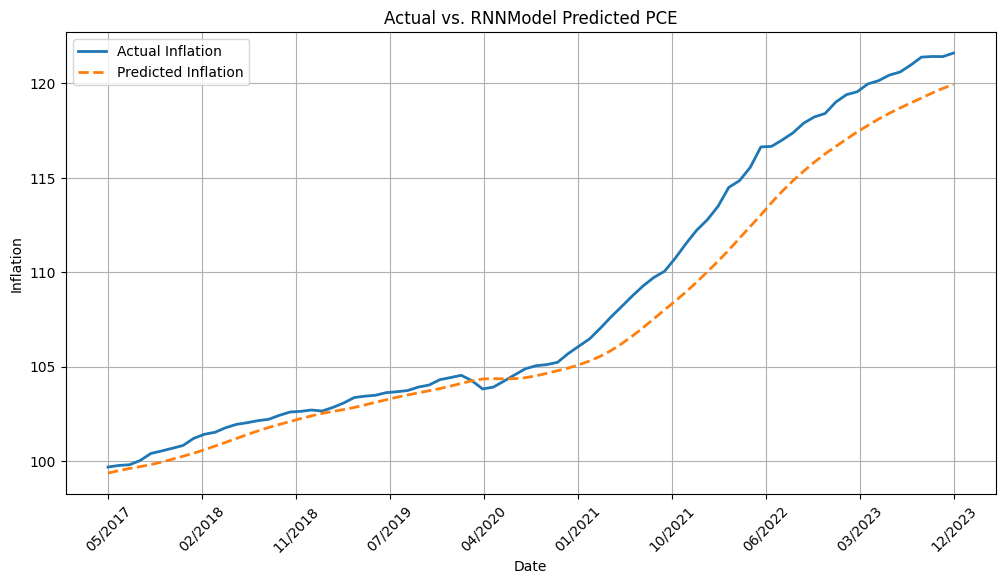

In [ ]:
# === Optuna-Tuned RNN Training and Evaluation ===

import torch
from Models.RNN import RNNModel
from Training.Helper.PyTorchModular import optuna_tune_and_train
from Evaluation.Helper.evaluation_helpers import get_best_model_path, evaluate_model
from Training.Helper.weightFileCleaner import cleanWeightFiles

# Step 1: Clean weight directory
model_save_path = "."  # Save models in current directory
cleanWeightFiles("RNN", dirPath=model_save_path, earlyStopped=False, verbose=True)

# Step 2: Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 3: Run Optuna Tuning + Training
best_model, best_params = optuna_tune_and_train(
    model_class=RNNModel,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    input_size=1,  # Univariate time series
    max_epochs=50,
    model_save_path=model_save_path,
    model_name="RNN",
    n_trials=20,
    verbose=True
)

# Step 4: Evaluate Best Model
val_dates = train_df[date_col].iloc[len(X_train) + sequence_length:].values
best_model_path = os.path.join(model_save_path, "RNN_best.pt")


eval_axes, metrics = evaluate_model(
    best_model, val_loader, scaler, val_dates,
    device, savepath=best_model_path, print_dates=10
)

# Step 5: Show evaluation metrics
print("Metrics for Optuna-Tuned RNN model:")
display(metrics)

import numpy as np
import os
import torch

# ==== RNN: Save Predictions (Similar to XGB Format) ====
def save_predictions(predictions, project_root, model_name="RNN"):
    pred_save_path = os.path.join(project_root, "Predictions", f"{model_name}.npy")
    np.save(pred_save_path, predictions)
    print(f"Saved {model_name} predictions to: {pred_save_path}")

def trim_and_save_predictions(predictions_path, n_trim=48):
    preds = np.load(predictions_path)
    preds_trimmed = preds[-n_trim:]
    np.save(predictions_path, preds_trimmed)
    print(f"Trimmed {os.path.basename(predictions_path)} to {len(preds_trimmed)} values and saved.")

# ==== Predict with the Best RNN Model ====
best_model.eval()
rnn_preds = []

with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        preds = best_model(X_batch).cpu().numpy().flatten()
        rnn_preds.extend(preds)

# Inverse transform predictions using your MinMaxScaler
rnn_preds = scaler.inverse_transform(np.array(rnn_preds).reshape(-1, 1)).flatten()

# Save and trim predictions
project_root = os.path.abspath(os.path.join("..", ".."))  # adjust if needed
predictions_dir = os.path.join(project_root, "Predictions")
os.makedirs(predictions_dir, exist_ok=True)

save_predictions(rnn_preds, project_root, model_name="RNN")
trim_and_save_predictions(os.path.join(predictions_dir, "RNN.npy"), n_trim=48)

